In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
wandb.init(mode="disabled")

In [3]:
train = pd.read_csv("./CSV-Dataset/with-remove-stopwords/train_data.csv")
test = pd.read_csv("./CSV-Dataset/with-remove-stopwords/test_data.csv")

# **INDOBERT**

In [4]:
# Preprocess data
X_train = train['combined'].tolist()
y_train = train['labels'].tolist()
X_test = test['combined'].tolist()
y_test = test['labels'].tolist()

In [5]:
# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(y_train)
test_labels_encoded = label_encoder.transform(y_test)

print("Encoded Labels:", train_labels_encoded)
print("Mapping (Label -> Angka):")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

Encoded Labels: [7 8 5 ... 7 3 3]
Mapping (Label -> Angka):
Infrastruktur dan Fasilitas Umum -> 0
Keadilan Hukum dan HAM -> 1
Kepegawaian -> 2
Kesehatan -> 3
Ketenagakerjaan dan Kesejahteraan Sosial -> 4
Lingkungan Hidup -> 5
Pendidikan -> 6
Perizinan dan Pertanahan -> 7
Teknologi Informasi dan Komunikasi -> 8


In [6]:
# Load pre-trained model and tokenizer
model_name = "indobenchmark/indobert-base-p1"  # Example IndoBERT model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(set(y_train))  # Assuming labels are integers
)

# Tokenize the data with optimizations
max_length = 128  # Adjust based on your dataset
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=max_length)

/mnt/e/Environment/pytorch/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Define custom dataset
class IndoBERTDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IndoBERTDataset(train_encodings, train_labels_encoded)
test_dataset = IndoBERTDataset(test_encodings, test_labels_encoded)

In [8]:
# Define metrics for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
        'precision': precision_score(labels, preds, average='weighted'),
        'recall': recall_score(labels, preds, average='weighted')
    }

In [ ]:
# Define training arguments with optimization
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Deep Learning/Final Project/Public Complaint Project/Model/indobert_results',                # Output directory
    num_train_epochs=5,                    # Number of training epochs
    per_device_train_batch_size=16,        # Training batch size
    per_device_eval_batch_size=64,         # Evaluation batch size
    warmup_steps=500,                      # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                     # Strength of weight decay
    logging_dir='./logs',                  # Directory for storing logs
    logging_steps=10,                      # Log every 10 steps
    evaluation_strategy="steps",           # Evaluate during training at each eval_steps
    eval_steps=100,                        # Evaluation steps
    save_strategy="steps",                 # Save checkpoints during training
    save_steps=100,                        # Save every 100 steps
    save_total_limit=2,                    # Limit the total checkpoints
    load_best_model_at_end=True,           # Load the best model when finished
    learning_rate=2e-5,                    # Learning rate
    lr_scheduler_type="linear",            # Learning rate scheduler type
    fp16=True,                              # Enable mixed precision training for efficiency
    report_to='none'
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Create Trainer instance with early stopping callback
trainer = Trainer(
    model=model,                           # The instantiated 🤗 Transformers model
    args=training_args,                    # Training arguments
    train_dataset=train_dataset,           # Training dataset
    eval_dataset=test_dataset,             # Evaluation dataset
    compute_metrics=compute_metrics,       # Custom evaluation metrics
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping
)

In [ ]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.946000,1.867038,0.341796,0.272518,0.488190,0.341796
200,0.744700,0.729665,0.819464,0.817403,0.827116,0.819464
300,0.593600,0.526356,0.841091,0.839648,0.842624,0.841091
400,0.490900,0.526289,0.840150,0.840176,0.846032,0.840150
500,0.467800,0.490630,0.856135,0.856574,0.863495,0.856135
600,0.472300,0.548145,0.836389,0.835287,0.852728,0.836389
700,0.464600,0.476080,0.858956,0.857141,0.860830,0.858956
800,0.506400,0.466782,0.863188,0.861459,0.864695,0.863188
900,0.238700,0.455657,0.864598,0.864671,0.869536,0.864598
1000,0.361400,0.421757,0.876352,0.875616,0.877853,0.876352


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1300, training_loss=0.6211764236596914, metrics={'train_runtime': 355.2203, 'train_samples_per_second': 119.743, 'train_steps_per_second': 7.488, 'total_flos': 1367605659087360.0, 'train_loss': 0.6211764236596914, 'epoch': 2.443609022556391})

In [ ]:
# Evaluate the model
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
print(f"Classification Report:\n{classification_report(test_labels_encoded, predicted_labels, target_names=label_encoder.classes_)}")

Classification Report:
                                          precision    recall  f1-score   support

        Infrastruktur dan Fasilitas Umum       0.90      0.95      0.92       187
                  Keadilan Hukum dan HAM       0.90      0.69      0.78       163
                             Kepegawaian       0.82      0.88      0.85       316
                               Kesehatan       0.87      0.87      0.87       263
Ketenagakerjaan dan Kesejahteraan Sosial       0.88      0.90      0.89       440
                        Lingkungan Hidup       0.76      0.80      0.78       115
                              Pendidikan       0.92      0.86      0.89       243
                Perizinan dan Pertanahan       0.91      0.91      0.91       226
      Teknologi Informasi dan Komunikasi       0.92      0.94      0.93       174

                                accuracy                           0.88      2127
                               macro avg       0.88      0.87      0.87  

In [ ]:
# Save the fine-tuned model
trainer.save_model("./fine_tuned_indobert")
tokenizer.save_pretrained("./fine_tuned_indobert")

In [ ]:
training_loss = trainer.state.log_history
training_loss_df = pd.DataFrame(training_loss)

# Extract relevant columns and save to a CSV file
training_loss_df[['loss', 'eval_loss']].to_csv('/content/drive/MyDrive/Deep Learning/Final Project/Public Complaint Project/Model/indobert/training_validation_loss.csv', index=False)

# **Load Model**

In [11]:
# Load the fine-tuned model and tokenizer
model_path = "./fine_tuned_indobert"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Make predictions
trainer = Trainer(model=model)  # No need for training arguments here
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Print the classification report
print(f"Classification Report:\n{classification_report(test_labels_encoded, predicted_labels, target_names=label_encoder.classes_)}")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Classification Report:
                                          precision    recall  f1-score   support

        Infrastruktur dan Fasilitas Umum       0.90      0.95      0.92       187
                  Keadilan Hukum dan HAM       0.90      0.69      0.78       163
                             Kepegawaian       0.82      0.88      0.85       316
                               Kesehatan       0.87      0.87      0.87       263
Ketenagakerjaan dan Kesejahteraan Sosial       0.88      0.90      0.89       440
                        Lingkungan Hidup       0.76      0.80      0.78       115
                              Pendidikan       0.92      0.86      0.89       243
                Perizinan dan Pertanahan       0.91      0.91      0.91       226
      Teknologi Informasi dan Komunikasi       0.92      0.94      0.93       174

                                accuracy                           0.88      2127
                               macro avg       0.88      0.87      0.87  

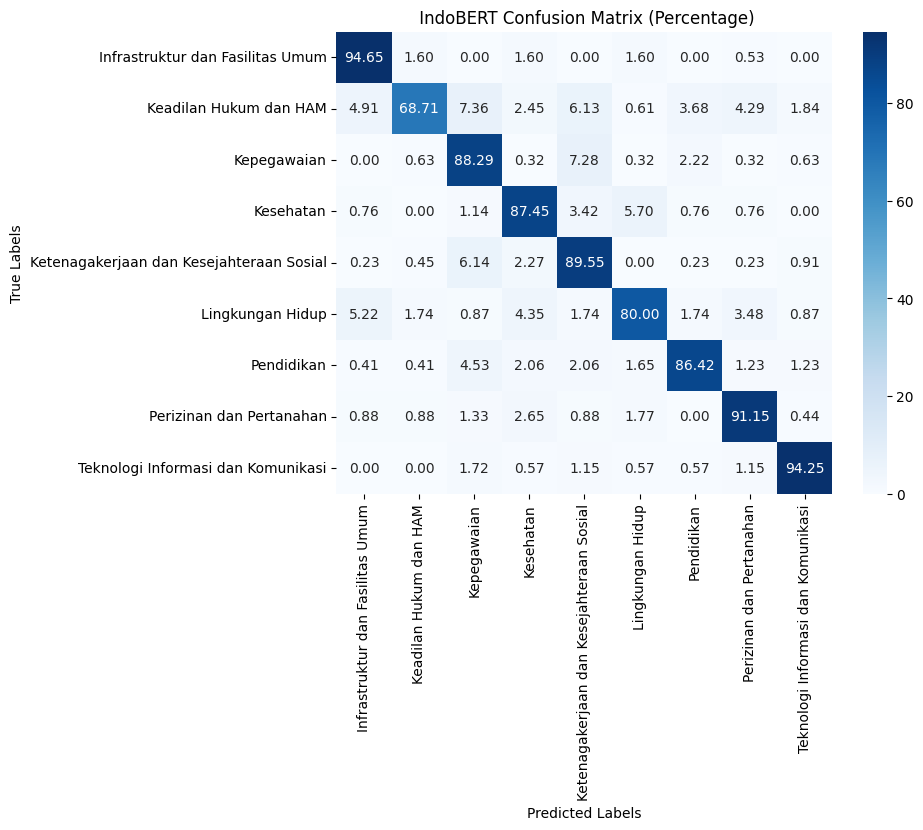

In [17]:
cm = confusion_matrix(test_labels_encoded, predicted_labels)

# Calculate the percentage for each cell
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix as percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(" IndoBERT Confusion Matrix (Percentage)")
plt.show()

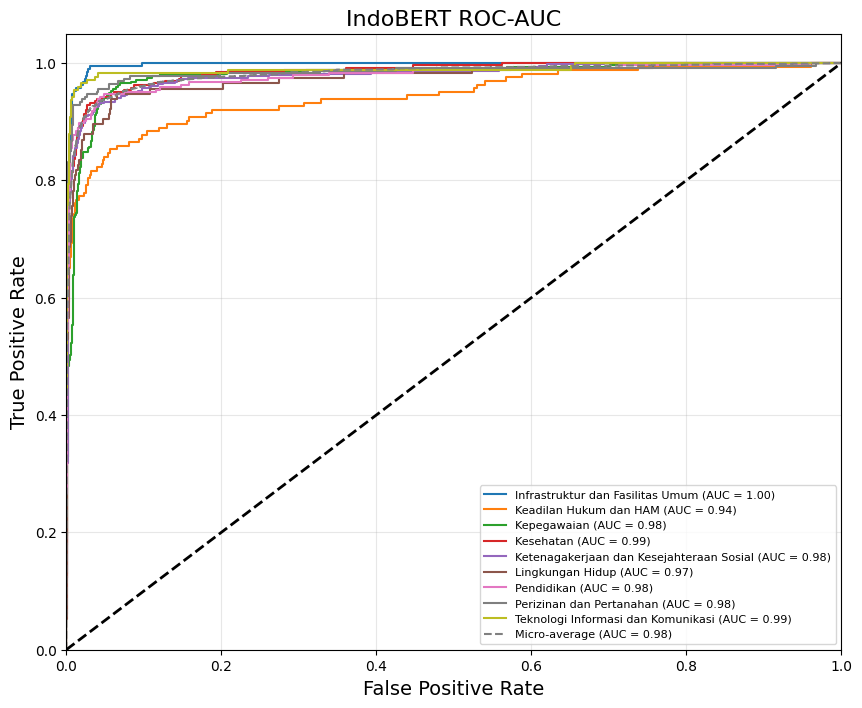

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities
probabilities = predictions.predictions
n_classes = probabilities.shape[1]

# Binarize the test labels for multi-class ROC
test_labels_binarized = label_binarize(test_labels_encoded, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_binarized.ravel(), probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10.colors  # Use a colormap for better visualization

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot(fpr["micro"], tpr["micro"], linestyle="--", color="gray",
         label=f"Micro-average (AUC = {roc_auc['micro']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('IndoBERT ROC-AUC', fontsize=16)
plt.legend(loc="lower right", fontsize=8)
plt.grid(alpha=0.3)
plt.show()